<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>04 - Main Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook a *Main Model* is proposed for the *Identifying the Human Values behind Arguments* task and evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

## Download of the Dataset

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_train_df.columns.to_list()

In [5]:
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
    split_dataframes(arguments_train_df, labels_train_df, seed=SEED)

# Model and Tokenizer Definition

In [6]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'bert-base-uncased'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, problem_type='multi_label_classification')

# Add the tokens encoding the stance to the tokenizer.
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

# Build a dictionary to encde the stance.
stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [8]:
from src.models.transformer_model  import get_transformer_model

model = get_transformer_model(MODEL_NAME, num_labels=len(TARGETS),
                              tokenizer=tokenizer, device=DEVICE)

In [9]:
print('Model structure:')
print(model)

Model structure:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## Training

### Create Dataloaders

In [10]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 16

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                             stance_encoder, is_transformer=True, 
                             batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                             use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                             stance_encoder, is_transformer=True,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                             stance_encoder, is_transformer=True,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)

### Training parameters

In [11]:
import os
from torch.optim import Adam
from src.training.training_utils import Checkpoint, EarlyStopping, FocalLoss

# Set the number of epochs.
EPOCHS = 15
# Set the learning rates for the Bert model and the Classification head.
LEARNING_RATE_BERT = 2e-05
LEARNING_RATE_CLASSIFIER = 1e-03
# Set how many training steps to use for validation.
STEPS_VALIDATE = 200

# Set the loss function.
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df))
train_labels_frequencies = train_labels_frequencies.to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Set the optimizer.
optimizer = Adam(params=[
    { 'params': model.bert.parameters(), 'lr': LEARNING_RATE_BERT },
    { 'params': model.dropout.parameters(), 'lr': LEARNING_RATE_CLASSIFIER },
    { 'params': model.classifier.parameters(), 'lr': LEARNING_RATE_CLASSIFIER }
    ])

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models', 'main_model.pth'))
early_stopping = EarlyStopping()

### Training

In [12]:
from src.training.training import train

# Train the model.
train_loss_history, val_loss_history, val_f1_macro_history = train(
    train_loader, val_loader, model, optimizer, loss_function, DEVICE,
    epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
    early_stopping=early_stopping, reload_best_weights=True,
    use_threshold_selection=True)

epoch: 1/15, 199/540, 33s 165ms/step, loss: 0.0626                
validate: 5s, validation loss: 0.0564, validation f1 macro: 42.4 %                
epoch: 1/15, 399/540, 64s 161ms/step, loss: 0.0593                
validate: 5s, validation loss: 0.0519, validation f1 macro: 46.9 %                
epoch: 1/15, 540/540, 88s 162ms/step, loss: 0.0581                
---------------------------------------------------------------
epoch: 1/15, 88s, loss: 0.0581, val loss:, 0.0515, val f1 macro: 48.1 %
epoch: 2/15, 199/540, 27s 137ms/step, loss: 0.0516                
validate: 5s, validation loss: 0.0497, validation f1 macro: 50.2 %                
epoch: 2/15, 399/540, 58s 146ms/step, loss: 0.0512                
validate: 5s, validation loss: 0.0496, validation f1 macro: 50.6 %                
epoch: 2/15, 540/540, 86s 158ms/step, loss: 0.0512                
---------------------------------------------------------------
epoch: 2/15, 86s, loss: 0.0512, val loss:, 0.0489, val f1 macro: 5

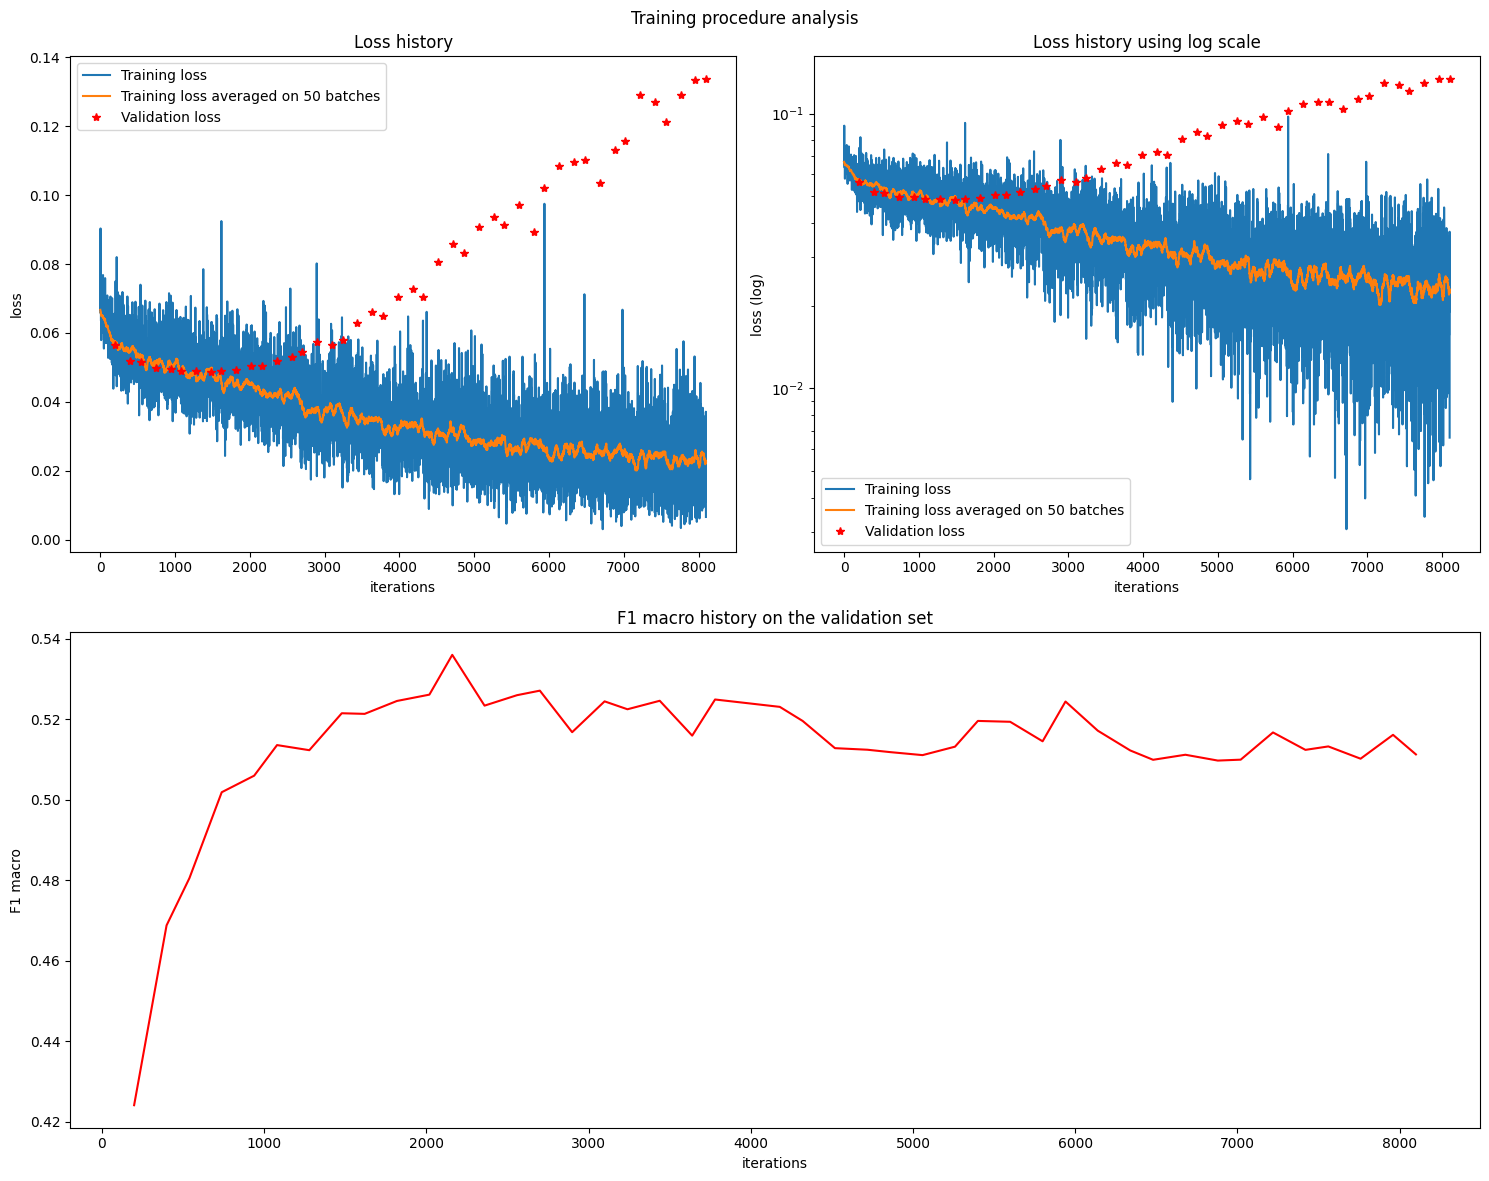

In [13]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

In [14]:
'''import torch

checkpoint = torch.load('models/main_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']'''

"import torch\n\ncheckpoint = torch.load('models/main_model.pth')\n\n# Get loss history and validation loss history\nmodel.load_state_dict(checkpoint['model_state_dict'])\ntrain_loss_history = checkpoint['train_loss_history']\nval_loss_history = checkpoint['val_loss_history']\nval_f1_macro_history = checkpoint['val_f1_macro_history']"

# Model Evaluation

## Threshold selection

Macro-averaged One-vs-Rest ROC AUC score:
0.82


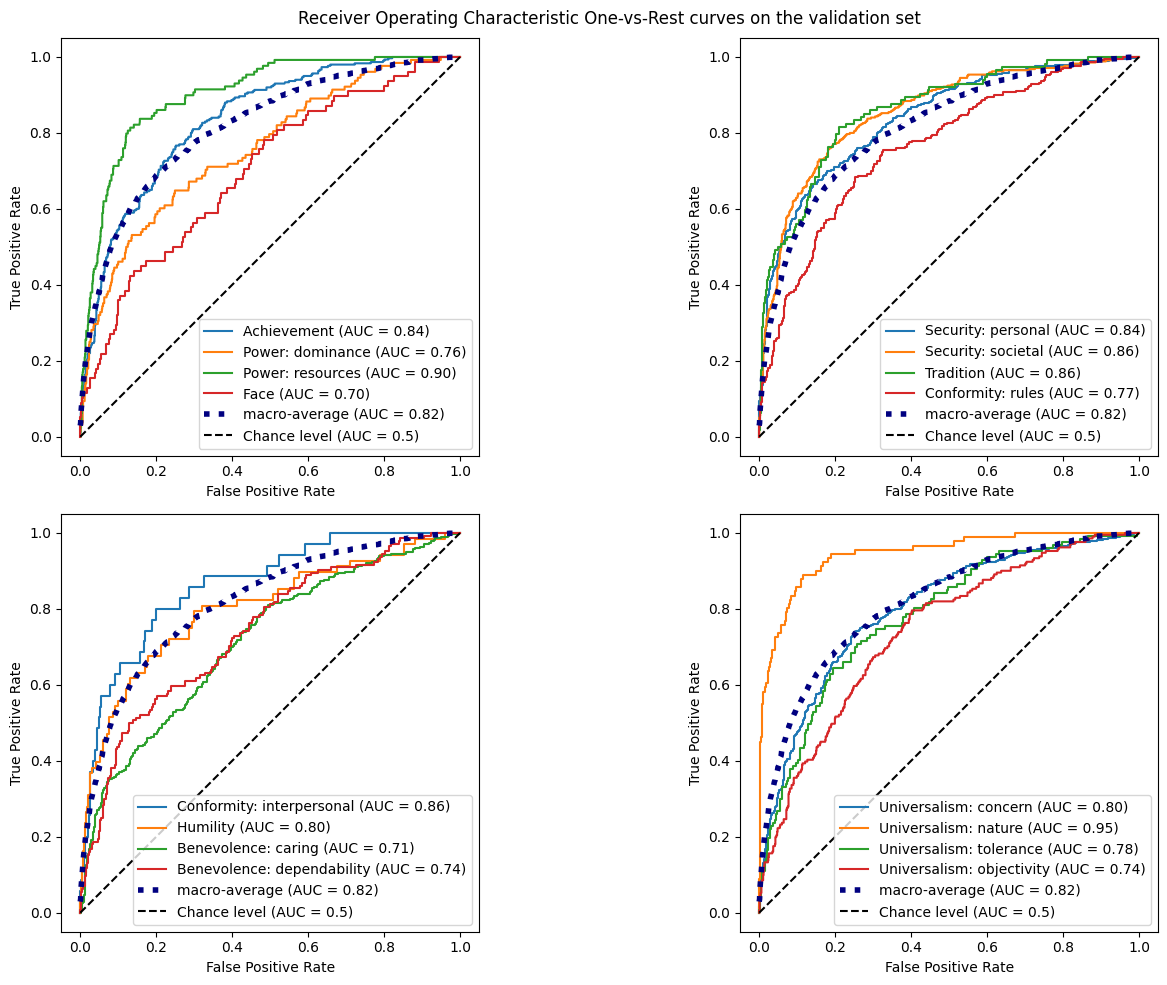

In [15]:
from src.evaluation.evaluation import get_dataset_prediction_scores
from src.evaluation.evaluation_analysis import plot_roc_curves

y_scores, y_true = get_dataset_prediction_scores(model, val_loader, DEVICE)
plot_roc_curves(y_true, y_scores, TARGETS, 'validation')

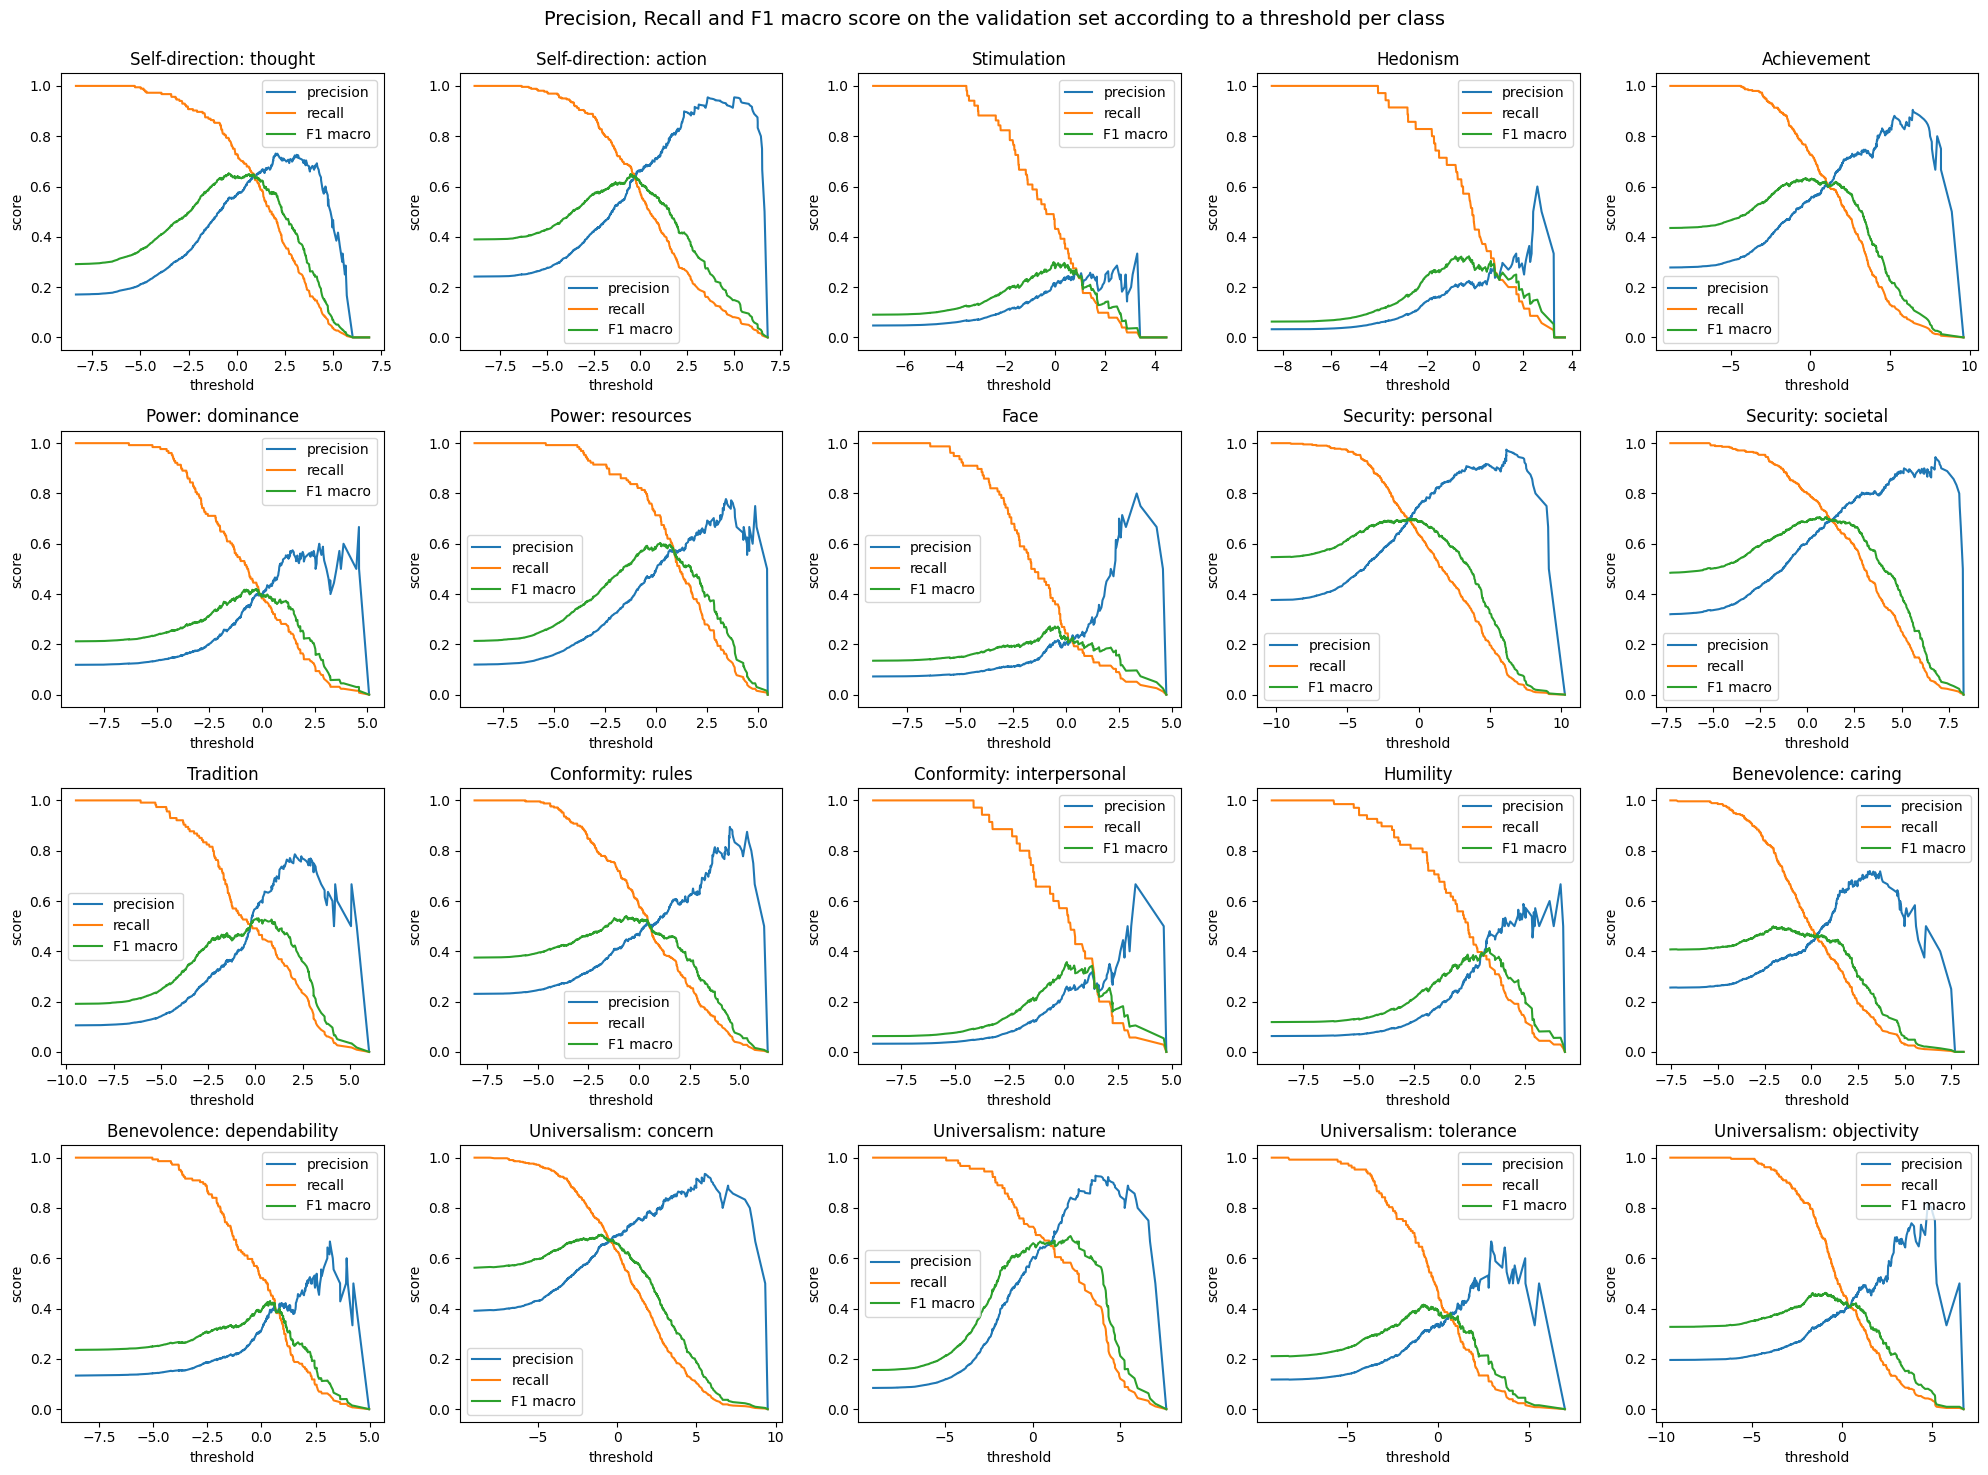

In [16]:
from src.evaluation.evaluation_analysis import (
    plot_precision_recall_f1_macro_curves)

plot_precision_recall_f1_macro_curves(y_true, y_scores, TARGETS, 'validation')

In [17]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'main_model_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: -0.4298
"Self-direction: action" best threshold: -0.5310
"Stimulation" best threshold: -0.0391
"Hedonism" best threshold: -0.2587
"Achievement" best threshold: -0.3106
"Power: dominance" best threshold: -0.2678
"Power: resources" best threshold: 0.2070
"Face" best threshold: -0.7681
"Security: personal" best threshold: -0.7153
"Security: societal" best threshold: 0.9485
"Tradition" best threshold: 0.1561
"Conformity: rules" best threshold: -0.6284
"Conformity: interpersonal" best threshold: 0.1453
"Humility" best threshold: 0.8847
"Benevolence: caring" best threshold: -2.0344
"Benevolence: dependability" best threshold: 0.3980
"Universalism: concern" best threshold: -0.9896
"Universalism: nature" best threshold: 2.1724
"Universalism: tolerance" best threshold: -0.7783
"Universalism: objectivity" best threshold: -0.9150


## Evaluation on the Validation set

In [18]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:', 
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.489


In [19]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE,
                                         thresholds_per_target)

# Compute Validation F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with threshold',
      f'selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.516


In [20]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.56      0.79      0.65       184
    Self-direction: action       0.62      0.68      0.65       261
               Stimulation       0.22      0.49      0.30        51
                  Hedonism       0.23      0.57      0.33        35
               Achievement       0.54      0.77      0.63       300
          Power: dominance       0.40      0.45      0.42       128
          Power: resources       0.53      0.71      0.61       129
                      Face       0.20      0.42      0.27        78
        Security: personal       0.70      0.70      0.70       406
        Security: societal       0.68      0.73      0.71       345
                 Tradition       0.60      0.48      0.53       114
         Conformity: rules       0.45      0.68      0.54       249
 Conformity: interpersonal       0.26      0.57      0.36        35
 

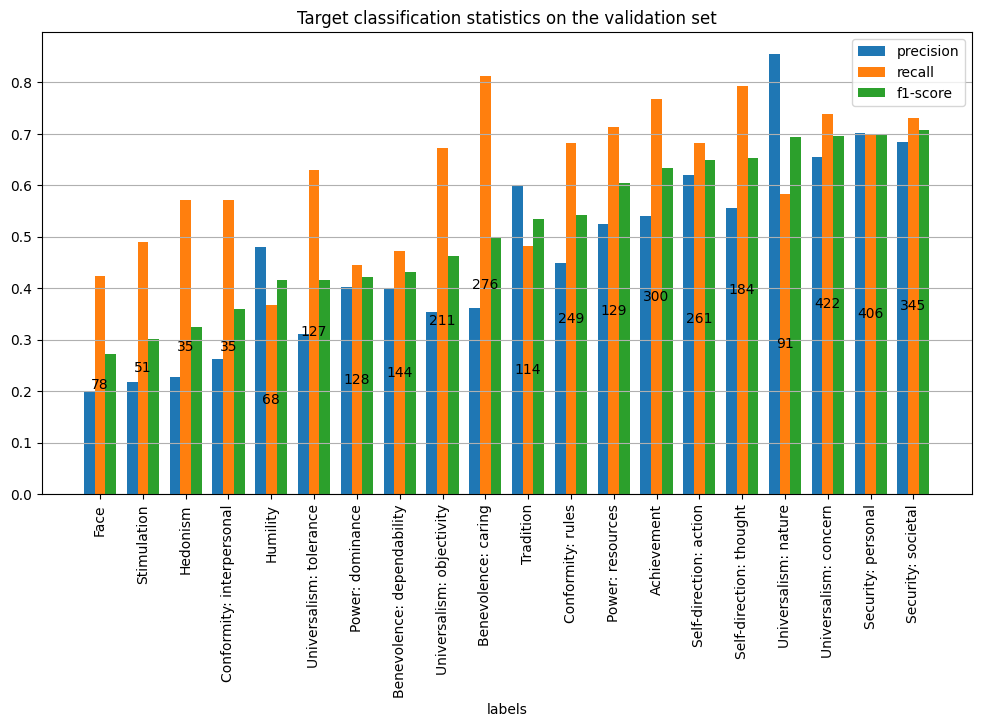

In [21]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')

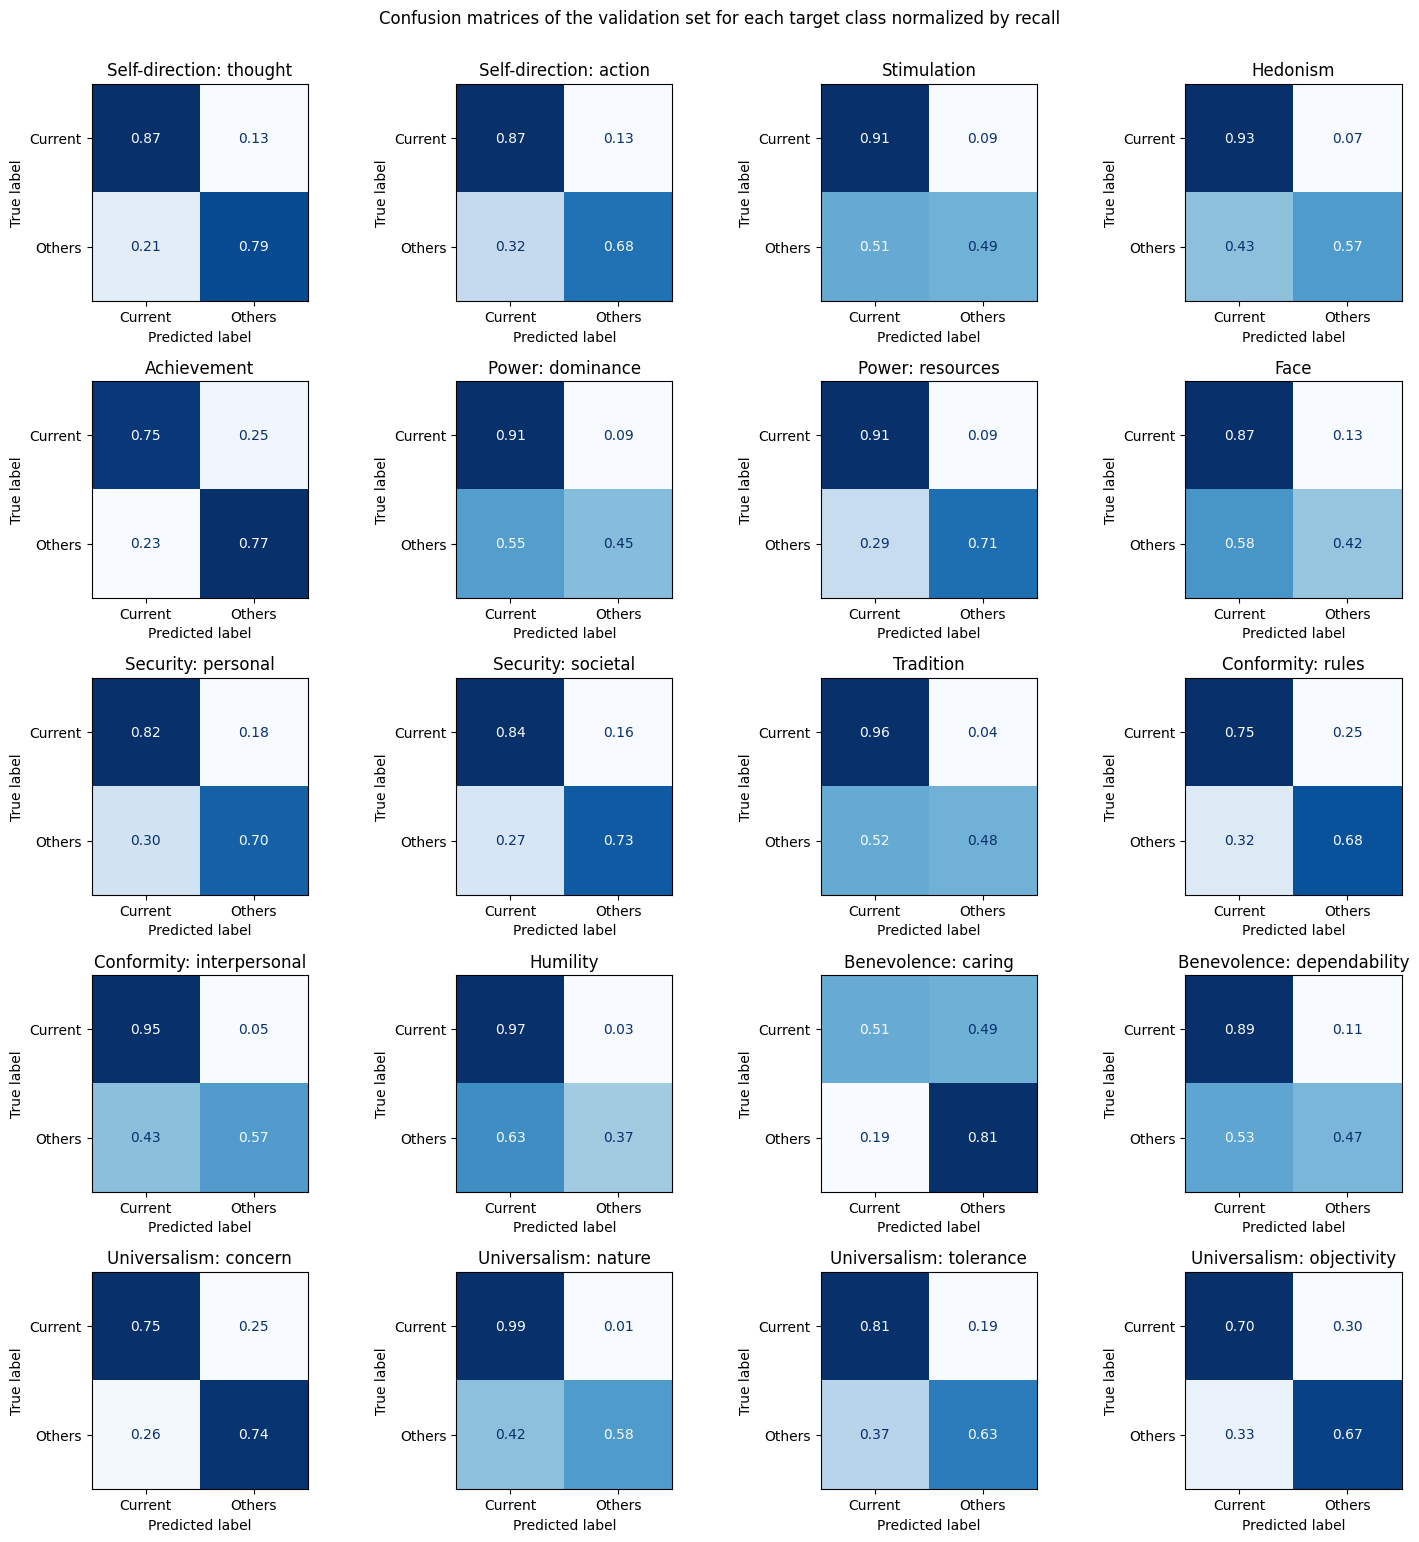

In [22]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation',
                        normalize_by='recall')

## Evaluation on the Test set

In [23]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.442


In [24]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                         thresholds_per_target)

# Compute Test F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with threshold selection:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.435


In [25]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.37      0.59      0.45       251
    Self-direction: action       0.52      0.58      0.55       496
               Stimulation       0.25      0.31      0.27       138
                  Hedonism       0.33      0.46      0.38       103
               Achievement       0.56      0.75      0.64       575
          Power: dominance       0.23      0.21      0.22       164
          Power: resources       0.38      0.66      0.49       132
                      Face       0.20      0.35      0.25       130
        Security: personal       0.72      0.76      0.74       759
        Security: societal       0.57      0.68      0.62       488
                 Tradition       0.55      0.40      0.46       172
         Conformity: rules       0.42      0.67      0.52       455
 Conformity: interpersonal       0.22      0.35      0.27        60
       

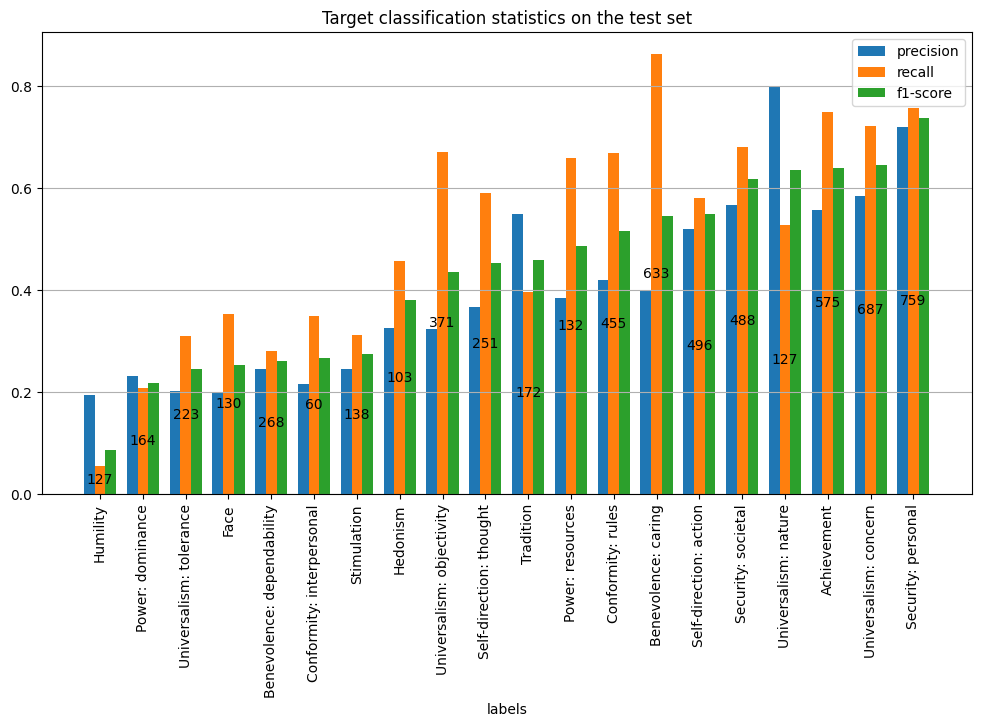

In [26]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')

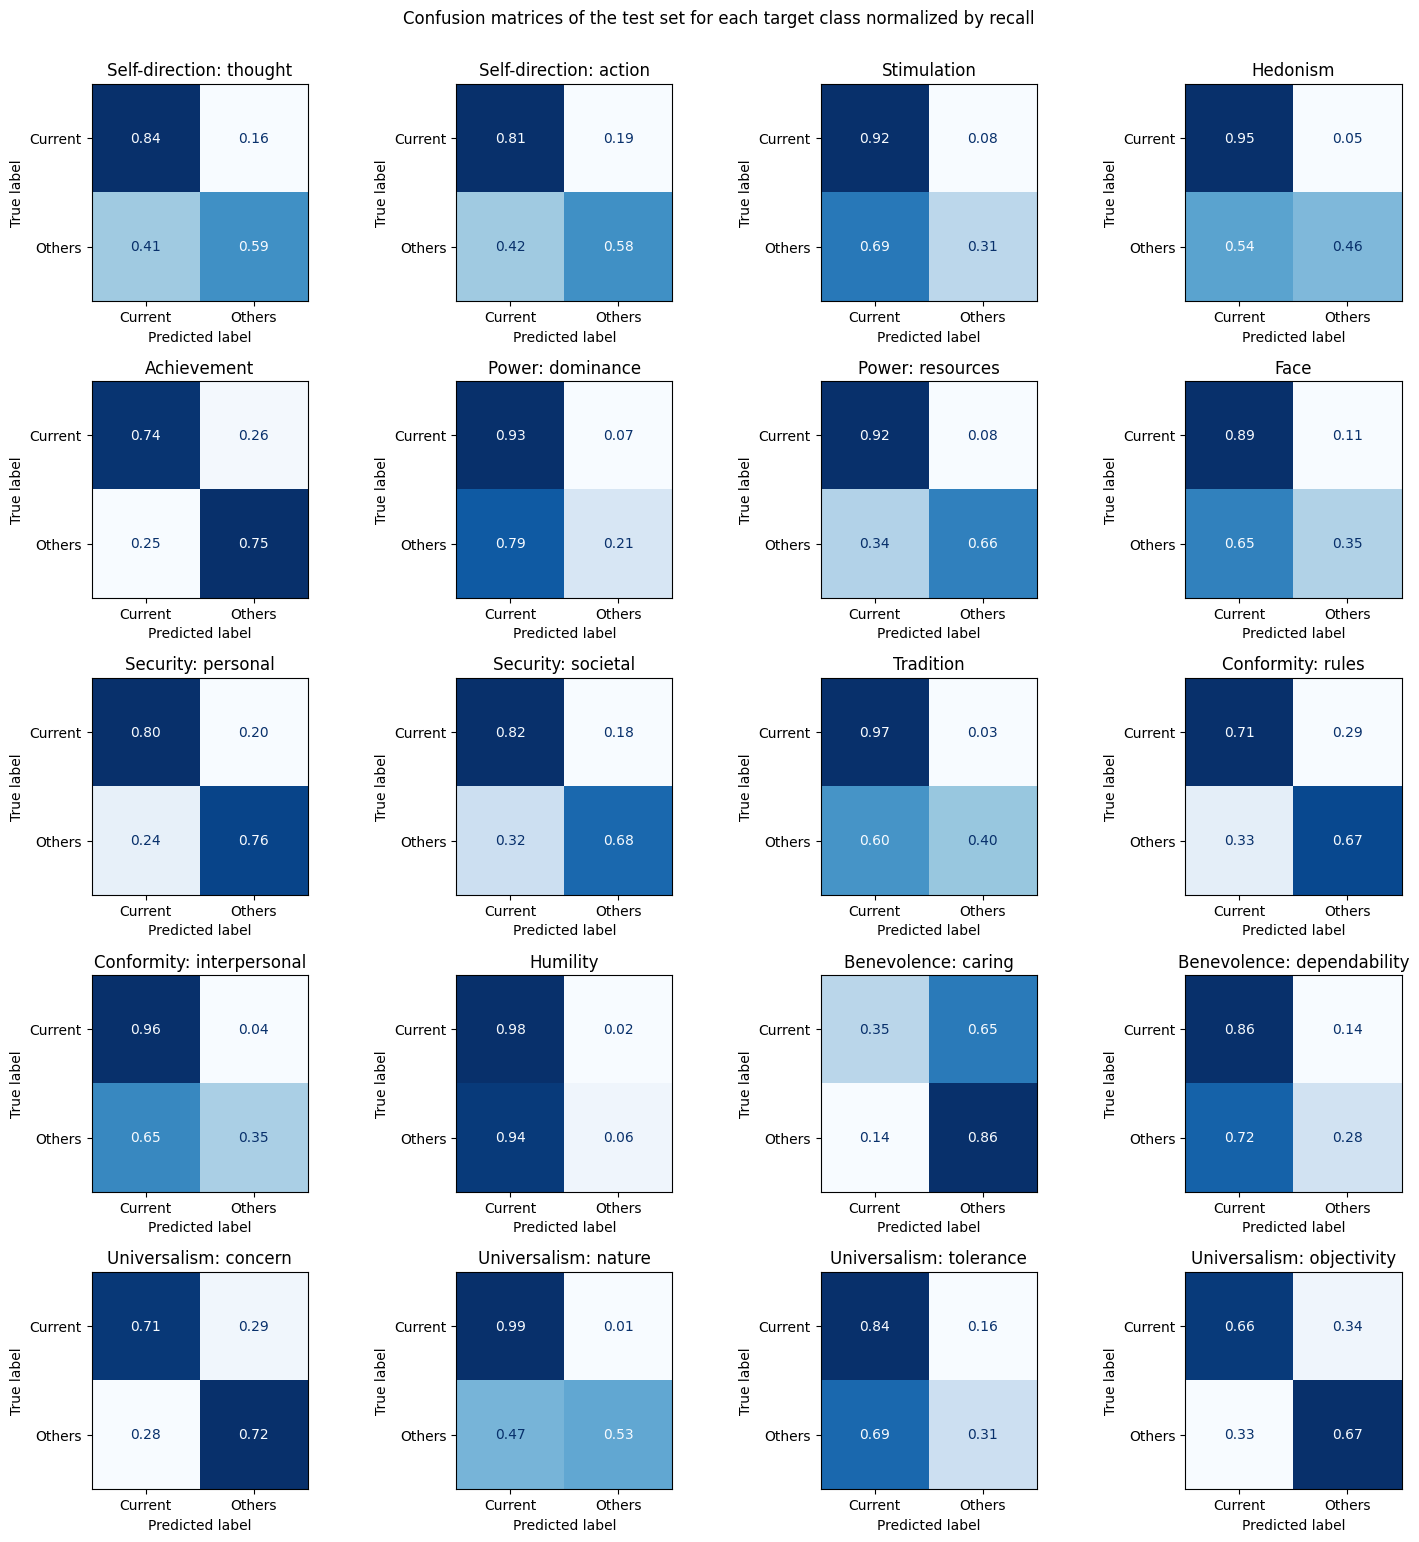

In [27]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test')

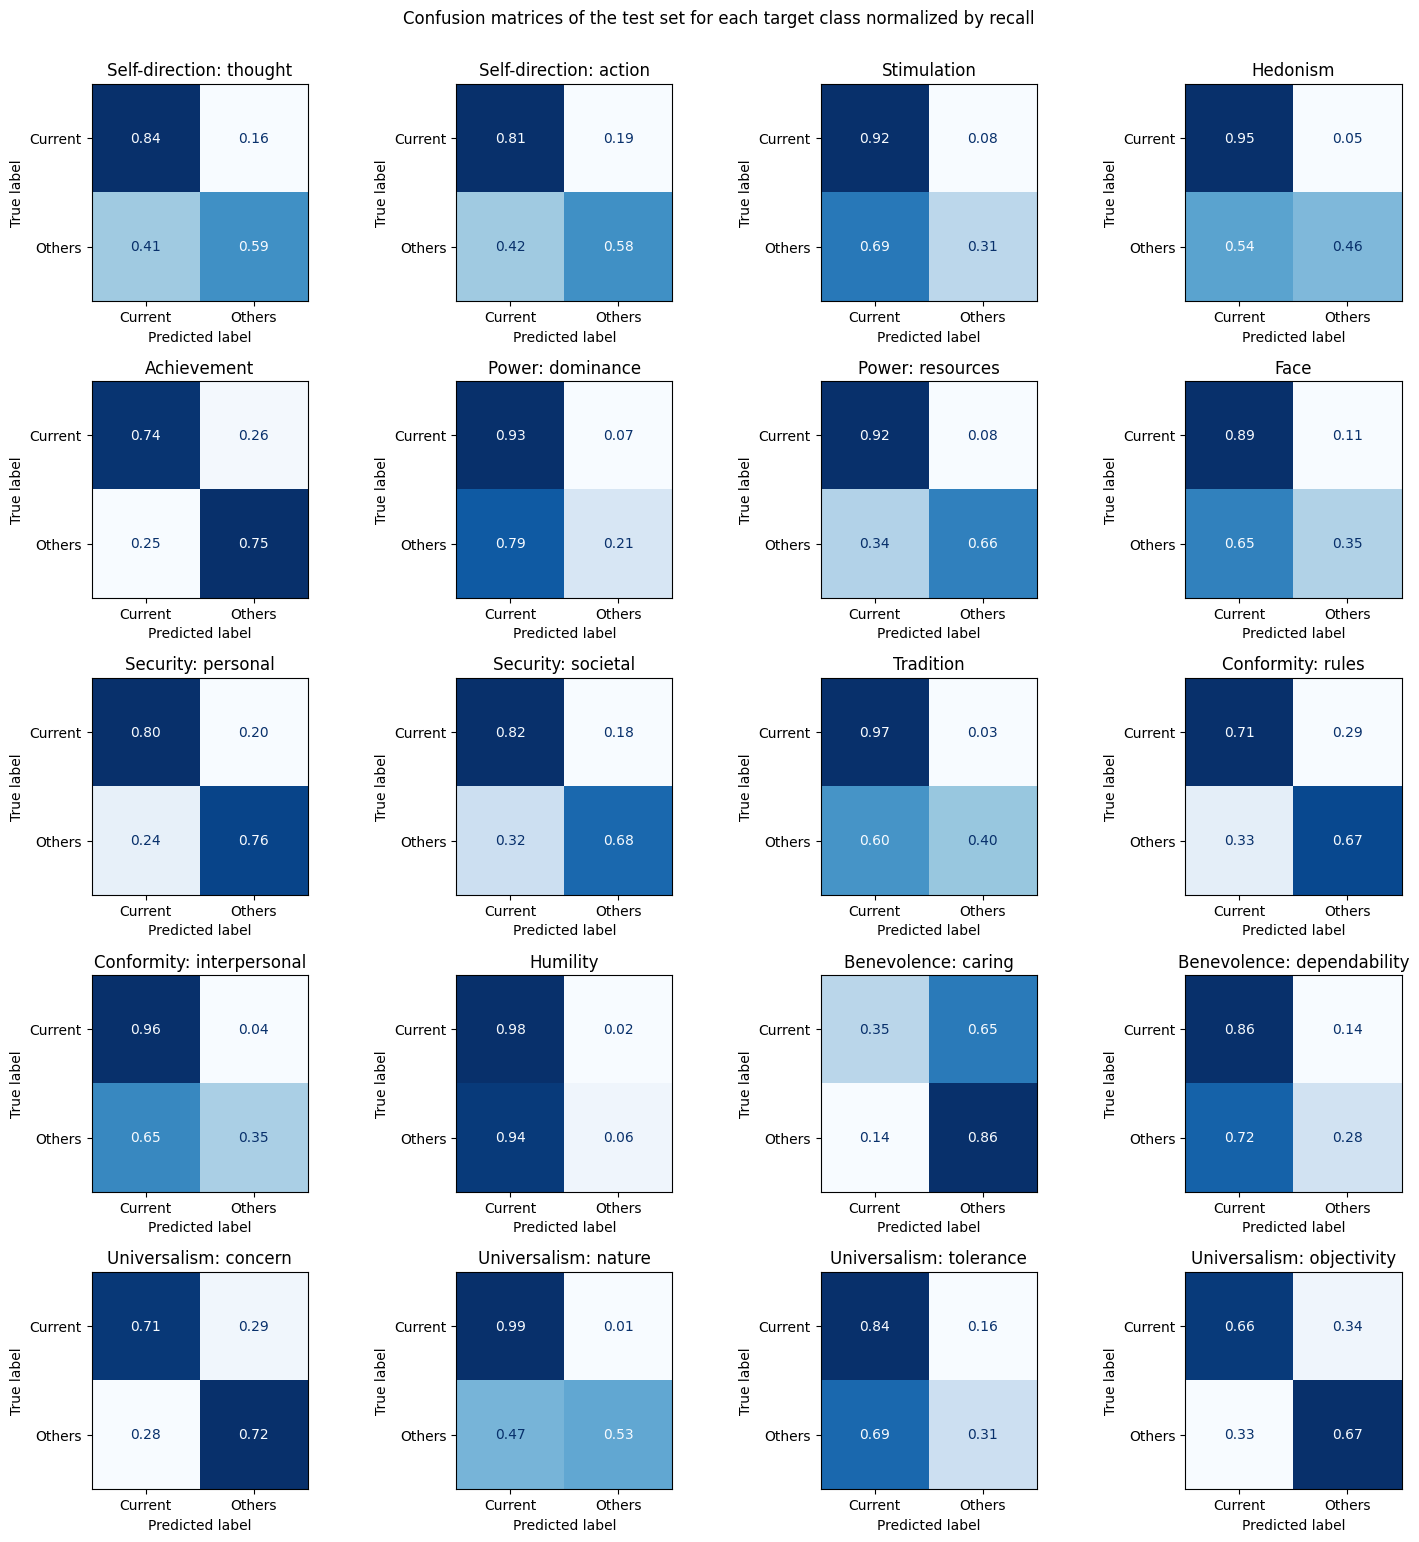

In [28]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test', normalize_by='recall')